In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation # LSTM -> 기억을 가지고 있다.
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

Using TensorFlow backend.


In [2]:
path = '/Users/hankiho/Desktop/네이버_과제/DSC2019_예선_데이터/'

In [3]:
st_data_koreaIndex = pd.read_csv(path + 'st_data_koreaIndex.tsv', delimiter='\t', header=0)
st_data_foreignCharge = pd.read_csv(path + 'st_data_foreignCharge.tsv', delimiter='\t', header=0)
st_data_exchange = pd.read_csv(path + 'st_data_exchange.tsv', delimiter='\t', header=0)
st_data_oilKorea = pd.read_csv(path + 'st_data_oilKorea.tsv', delimiter='\t', header=0)
st_data_goldKorea = pd.read_csv(path + 'st_data_goldKorea.tsv', delimiter='\t', header=0)
st_data_oilForeign = pd.read_csv(path + 'st_data_oilForeign.tsv', delimiter='\t', header=0)
st_data_goldForeign = pd.read_csv(path + 'st_data_goldForeign.tsv', delimiter='\t', header=0)
st_data_goodsForeign = pd.read_csv(path + 'st_data_goodsForeign.tsv', delimiter='\t', header=0)

In [4]:
dt = st_data_exchange[(st_data_exchange['itemname2'] == '일본JPY (100엔)') |
                (st_data_exchange['itemname2'] == '홍콩HKD') |
                (st_data_exchange['itemname2'] == '태국THB') |
                (st_data_exchange['itemname2'] == '대만TWD') |
                (st_data_exchange['itemname2'] == '미국USD') |
                (st_data_exchange['itemname2'] == '필리핀PHP') |
                (st_data_exchange['itemname2'] == '베트남VND 100')]
dt = dt[['date', 'cash_buying_val', 'itemname2']]
dt_exchange = dt.pivot(index = 'date',
                       columns = 'itemname2',
                       values = 'cash_buying_val')
dt_exchange.head()

itemname2,대만TWD,미국USD,베트남VND 100,일본JPY (100엔),태국THB,필리핀PHP,홍콩HKD
date,,,,,,,
20150107,37.15,1118.74,5.74,939.80,35.42,26.86,144.61
20150113,36.75,1102.15,5.67,931.89,34.94,26.62,142.49
20150116,36.89,1096.35,5.65,939.30,35.02,26.54,141.74
20150119,36.99,1097.47,5.65,936.00,35.08,26.63,141.92
20150122,37.29,1103.68,5.67,936.43,35.26,26.98,142.71


In [5]:
da = st_data_koreaIndex[['date','itemcode','close_val']]
dt_koreaindex = da.pivot(index = 'date',
                        columns = 'itemcode',
                        values = 'close_val')
dt_koreaindex.head()

itemcode,KOSDAQ,KOSPI,KPI200
date,,,
20150107,56132,188383,24053
20150113,57100,191714,24629
20150116,57741,188813,24222
20150119,57794,190262,24478
20150122,57842,192082,24847


In [6]:
dt_oilkorea = st_data_oilKorea[['date','close_val']]
dt_goldkorea = st_data_goldKorea[['date','sell_val','international_val']]
dt_goldkorea.head()

,date,sell_val,international_val
0,20150107,40886.06,1214.85
1,20150113,41112.99,1242.45
2,20150116,41413.58,1257.92
3,20150119,42031.36,1275.50
4,20150122,42669.34,1287.70


In [7]:
dg = st_data_goldForeign[['date','itemname','close_val']]
dt_goldForeign = dg.pivot(index = 'date',
                         columns = 'itemname',
                         values = 'close_val')
dt_goldForeign.head(5)

itemname,국제 금,백금,은,팔라듐
date,,,,
20150107,1210.6,1220.7,16.510,792.4
20150113,1234.3,1247.4,17.125,815.7
20150116,1276.9,1269.8,17.739,754.3
20150119,1276.6,1264.0,17.770,791.5
20150122,1300.7,1284.0,18.346,773.6


In [8]:
def LSTM(data, day, batch_size, epochs, div_ratio):
    #필요한 패키지를 불러온다
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from keras.models import Sequential #Sequential는 층을 순서대로 쌓아주는 클래스
    from keras.layers import LSTM, Dropout, Dense, Activation
    import datetime

    #몇일을 예측 할 건지 정의
    seq_len = day
    sequence_length = seq_len + 1

    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    #데이터 정규화
    normalized_data = []
    for window in result:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)

    result = np.array(normalized_data)
    #학습데이터와 테스트테이터를 나줘줌
    row = int(round(result.shape[0] * div_ratio))
    train = result[:row, :]
    np.random.shuffle(train)

    x_train = train[:, :-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = train[:, -1]

    x_test = result[row:, :-1]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = result[row:, -1]
    #모델 빌드
    model = Sequential()
    model.add(LSTM(day, return_sequences = True, input_shape = (day, 1))) #input를 맞쳐줘야된다
    model.add(LSTM(64, return_sequences = False))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'rmsprop')
    model.summary()
    #모델 핏팅
    model.fit(x_train, y_train,
        validation_data = (x_test, y_test),
        batch_size = batch_size,
        epochs = epochs)
    
    pred = model.predict(x_test)
    fig = plt.figure(facecolor = 'white', figsize = (20, 10))
    ax = fig.add_subplot(111)
    ax.plot(y_test, label = 'True')
    ax.plot(pred, label = 'Prediction')
    ax.legend()
    plt.show()

In [9]:
japan = np.array(dt_exchange['일본JPY (100엔)'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 190 samples, validate on 82 samples
Epoch 1/30
190/190 [==============================] - 4s 19ms/step - loss: 0.0024 - val_loss: 3.4013e-04
Epoch 2/30
190/190 [==============================] - 2s 11ms/step - loss: 0.0010 - val_loss: 3.1635e-04
Epoch 3/30
190/190 [=======

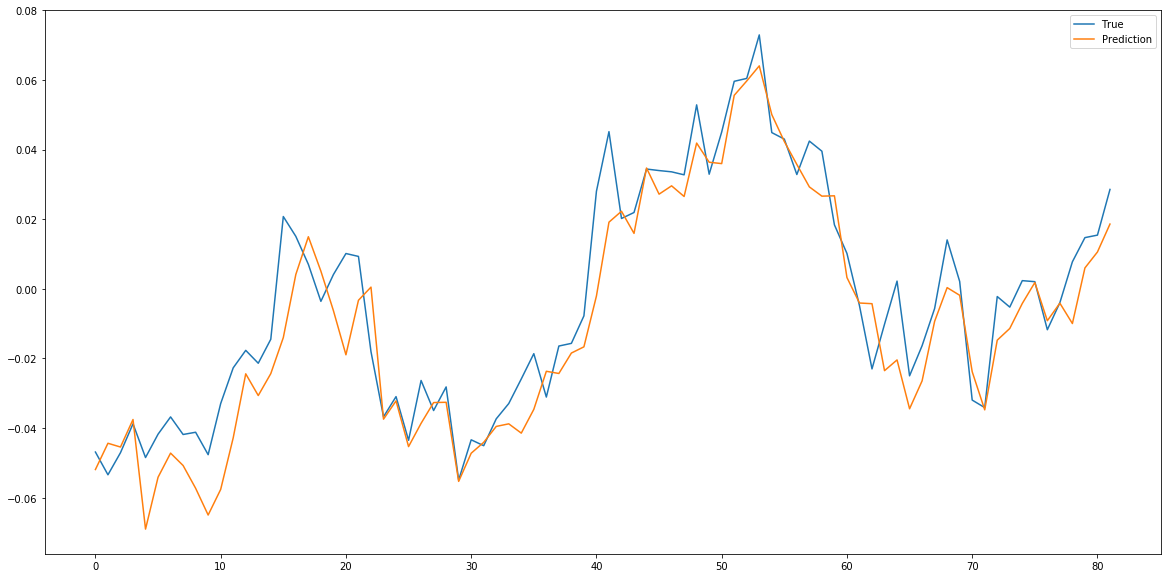

In [10]:
LSTM(japan,50,10,30,0.7)